In [1]:
import sklearn.ensemble
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pyproj import Proj
import ast
os.chdir('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania')

### functions

In [2]:
#coordinates conversion
def convert_easting_northing_to_lat_lon(easting, northing,):
    proj = Proj('+proj=utm +zone=55 +south +ellps=GRS80 +units=m +no_defs')
    lon, lat = proj(easting, northing, inverse=True)
    return lat, lon

In [3]:
#convert asc file to geopandas
def asc2gpd(info,grid):

    #seperate text and int
    info['name']=[i.split(' ')[0] for i in info[0]]
    info['val']=[float(i.split(' ')[-1] )for i in info[0]]

    #convert to int for lower left x,y, nodatavalue and cell size
    xllcorner=info['val'][info['name']=='xllcorner'].item()
    xllcorner=int(xllcorner)
    yllcorner=info['val'][info['name']=='yllcorner'].item()
    yllcorner=int(round(yllcorner))
    cellsize=info['val'][info['name']=='cellsize'].item()
    cellsize=int(cellsize)
    nodataval=info['val'][info['name']=='NODATA_value'].item()
    nodataval=int(nodataval)

    #get coordinates in matrix form
    nrow=range(yllcorner,yllcorner+cellsize*grid.shape[0],cellsize)
    ncol=range(xllcorner,xllcorner+cellsize*grid.shape[1],cellsize)

    #flip y coordinates
    flatarr=[(i,j) for j in nrow for i in ncol]
    y=np.flip(np.array([i[1] for i in flatarr]).reshape(grid.shape),axis=0).flatten().tolist()

    #create geopandas
    export=pd.DataFrame()
    export['coords']=list(zip([i[0] for i in flatarr],y))
    export['altitude']=grid.flatten()
    export['coords'] = export['coords'].apply(shapely.geometry.Point)
    output=gpd.GeoDataFrame(export, geometry='coords')

    #remove nodata point
    output=output[output['altitude']!=nodataval]    
    
    return output

### global variables

In [4]:
lonmin=144.165967
latmin=-43.833736
lonmax=148.576978
latmax=-40.349895
lat_centre =-42.10904672752227 ; lon_centre = 146.6417533511285;
gridlen=35

radius=1.2
bbox=box(lonmin,latmin,lonmax,latmax)

### island map

In [5]:
df_baselayer=pd.read_csv('./poems/baselayer.csv')

### devils

In [6]:
#read data
rel_abun=pd.read_csv('./data/rel_abun.csv')
rel_abun['id']=rel_abun['id'].apply(lambda x:ast.literal_eval(x))

#convert to matrix
devil=np.array([[np.nan]*gridlen]*gridlen)
for i in rel_abun.index:
    devil[rel_abun.at[i,'id']]=rel_abun.at[i,'rel_abun']
devil=np.flip(devil,axis=0)

### disease arrival

In [7]:
#read
arrival=pd.read_csv('./data/disease arrival.csv')
arrival['id']=arrival['id'].apply(lambda x:ast.literal_eval(x))
arrival=arrival.merge(rel_abun[['id','disease length']],on='id',how='left')

In [8]:
#convert to matrix
dismat=np.array([[np.nan]*gridlen]*gridlen)
for i in arrival.index:
    dismat[arrival.at[i,'id']]=arrival.at[i,'disease length']
dismat=np.flip(dismat,axis=0)

### vegetation

In [9]:
vegdata=pd.read_csv('./poems/vegdata.csv')

### elevation

In [10]:
height=pd.read_csv('./poems/height.csv')

In [11]:
#remove grid cells outside of the areas
for i in range(len(height)):
    if int(height['id'][i].split(',')[0].split('(')[-1])>=gridlen or \
    int(height['id'][i].split(',')[-1].split(')')[0])>=gridlen or \
    int(height['id'][i].split(',')[0].split('(')[-1])<0 or int(height['id'][i].split(',')[-1].split(')')[0])<0:
        height.drop(i,inplace=True)

In [12]:
#generate raster
altitude=np.zeros(devil.shape)
for i in range(len(height)):
    altitude[eval(height.at[i,'id'])]=height.at[i,'altitude']
altitude=np.flip(altitude,axis=0)

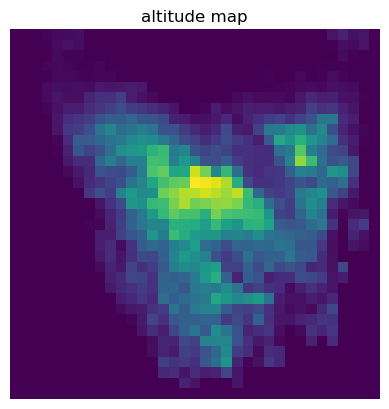

In [13]:
#viz
plt.imshow(altitude)
plt.title('altitude map')
plt.axis('off')
plt.show()

### matrix form

In [14]:
#generate data
data=pd.DataFrame()
data['devil']=devil.flatten()
data['index']=data['devil']
data['altitude']=altitude.flatten()
data['disease']=dismat.flatten()

#convert array to binary
arr=np.array(df_baselayer['grid'])
arr[arr==0]=1
arr[arr==255]=0
data['base']=arr

#get veg
data=pd.concat([data,vegdata],axis=1)

### random forest

In [15]:
#remove sea area
land=data[data['base']==1]

#only work on the cells with recorded devil capture
training=land.loc[land['index'].dropna().index]

In [16]:
#train and predict

targets=[i for i in training.columns if i not in ['devil','base','index']]
clf=sklearn.ensemble.RandomForestRegressor(n_estimators=1000,max_depth=50,)

clf.fit(training[targets],training['index'])

RandomForestRegressor(max_depth=50, n_estimators=1000)

In [17]:
land['disease']=1
land['pred']=clf.predict(land[targets])

data['pred']=land['pred']

C:\Users\tm\AppData\Local\Temp\ipykernel_53260\3832839134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land['disease']=1
C:\Users\tm\AppData\Local\Temp\ipykernel_53260\3832839134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land['pred']=clf.predict(land[targets])


In [18]:
#not bad for scarce data points
clf.score(training[targets],training['index'])

0.8652153874894946

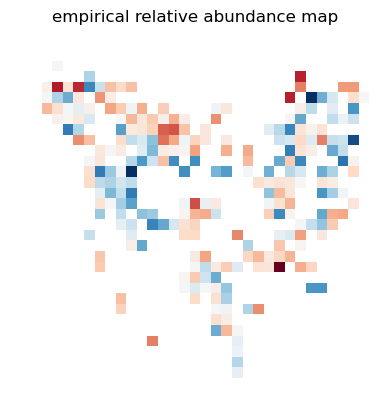

In [19]:
plt.imshow(devil,cmap='RdBu_r')
plt.axis('off')
plt.title('empirical relative abundance map')
plt.show()

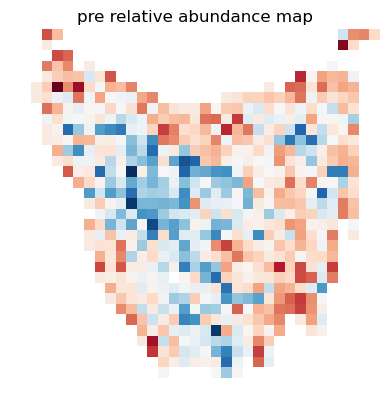

In [20]:
#viz habitat suitability map
plt.imshow(np.array(data['pred']).reshape(gridlen,gridlen),cmap='RdBu_r')
plt.title('pre relative abundance map')
plt.axis('off')
plt.show()

In [21]:
land['pred'].loc[land['index'].dropna().index]=land['index'][land['index'].dropna().index].tolist()

C:\Users\tm\AppData\Local\Temp\ipykernel_53260\1000287191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land['pred'].loc[land['index'].dropna().index]=land['index'][land['index'].dropna().index].tolist()


In [22]:
land[['pred']].dropna().to_csv('./poems/suitability.csv',index=False)

In [23]:
#create map data
arr=data['base'].to_numpy()
arr[arr==0]=255
arr[arr==1]=0
df_baselayer=pd.DataFrame()
df_baselayer['grid']=arr
df_baselayer.to_csv('./poems/baselayer.csv',index=False)

In [24]:
#convert lattice to adjacency list
check_matrix=arr.reshape(gridlen,gridlen)
adj_list={}

for i in range(gridlen**2):
    current_tile=[i//gridlen,i%gridlen]
    
    if check_matrix[current_tile[0],current_tile[1]]==0:
        adj_list[i]=[]
        
        up=[current_tile[0]-1,current_tile[1]]
        down=[current_tile[0]+1,current_tile[1]]
        left=[current_tile[0],current_tile[1]-1]
        right=[current_tile[0],current_tile[1]+1]

        
        if up[0]>=0 and check_matrix[current_tile[0]-1,current_tile[1]]==0:
            adj_list[i].append(i-gridlen)

        if down[0]<gridlen and check_matrix[current_tile[0]+1,current_tile[1]]==0:
            adj_list[i].append(i+gridlen)
        
        if left[1]>=0 and check_matrix[current_tile[0],current_tile[1]-1]==0:
            adj_list[i].append(i-1)

        if right[1]<gridlen and check_matrix[current_tile[0],current_tile[1]+1]==0:
            adj_list[i].append(i+1)
            

In [25]:
#use bfs to identify the grids required for validation within the radius
counter=0
stop=False
lvl={}
lvl[0]=training[training['index']!=0].index.tolist()
while not stop:
    
    queue=[]
    counter+=1
    if counter>radius:
        stop=True
    for i in list(lvl.values())[-1]:
        queue+=adj_list[i]
    lvl[counter]=list(set(queue))

validation_target=sorted(list(set([j for i in lvl.values() for j in i])))

In [26]:
#create validation area file
valid=pd.DataFrame(index=df_baselayer.index)
valid['target']=0
valid['target'].loc[validation_target]=1
valid.to_csv('./poems/validation.csv',index=False)

In [27]:
#reindex validation area against land area
land['ID']=range(len(land))
identity=pd.DataFrame()
identity['ID']=land['ID'].loc[validation_target].tolist()
identity.to_csv('./poems/identity.csv',index=False)

C:\Users\tm\AppData\Local\Temp\ipykernel_53260\617944699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land['ID']=range(len(land))
